# Git Storage Model

## Description
https://wiki/display/gqd/Git+Storage

gas_storage5

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)

In [3]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime, date

In [4]:
#a number of utilities:
from gmt.fom.gas.shared.utils.common import pa
from gmt.fom.gas.shared.utils.dframe import ddff
from gmt.fom.gas.shared.utils.common import flatten_lst

In [5]:
from gmt.fom.gas.shared.models.git_storage.git_storage import GitStorageModel

In [6]:
import cmdty_storage

In [7]:
sys.path.append(r'C:\git\storage-master\samples\python')

In [8]:
import logging

In [9]:
logger = logging.getLogger()

In [10]:
logger.setLevel(logging.INFO)

# Market

## Forward

In [11]:
from gmt.fom.gas.shared.models.git_storage.data.fwd import Forward

In [12]:
forward = Forward(True,True,0.999)

In [13]:
forward.params

{'smooth_curve': True,
 'apply_weekend_shaping': True,
 'weekend_shaping_factor': 0.999}

In [14]:
forward.curve

2021-01-20    18.440949
2021-01-21    18.456697
2021-01-22    18.472437
2021-01-23    18.469662
2021-01-24    18.485310
                ...    
2022-04-26    17.095956
2022-04-27    17.070184
2022-04-28    17.044411
2022-04-29    17.018637
2022-04-30    16.975871
Freq: D, Length: 466, dtype: float64

<AxesSubplot:>

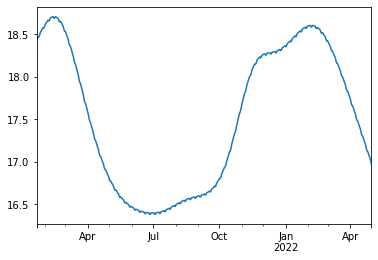

In [15]:
forward.curve.plot()

## IR

In [16]:
from gmt.fom.gas.shared.models.git_storage.data.ir import Ir

In [17]:
ir = Ir()

In [18]:
ir.curve

date
2021-04-25    0.005000
2021-04-26    0.005027
2021-04-27    0.005054
2021-04-28    0.005081
2021-04-29    0.005108
                ...   
2023-11-27    0.012588
2023-11-28    0.012591
2023-11-29    0.012594
2023-11-30    0.012597
2023-12-01    0.012600
Freq: D, Name: rate, Length: 951, dtype: float64

<AxesSubplot:xlabel='date'>

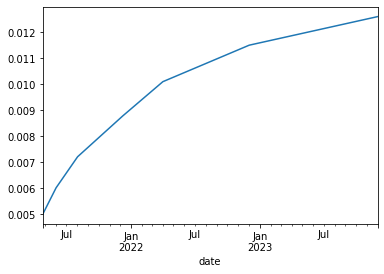

In [19]:
ir.curve.plot()

# Storage

In [20]:
from gmt.fom.gas.shared.models.git_storage.data.storage import Storage

In [25]:
str_type = 'NOT SIMPLE'

if str_type == 'SIMPLE':
    storage = Storage('SIMPLE', 
                  freq='D',
                  storage_start='2021-04-01',
                  storage_end='2022-04-01',
                  injection_cost=0.01,
                  withdrawal_cost=0.025,
                  #Specific to SIMPLE type:
                  min_inventory=0.0,
                  max_inventory=1500.0,
                  max_injection_rate=25.5,
                  max_withdrawal_rate=30.9)
else:
    storage = Storage('RATCHETS', 
                  freq='D',
                  storage_start='2021-04-01',
                  storage_end='2022-04-01',
                  injection_cost=0.01,
                  withdrawal_cost=0.025)

In [26]:
storage.params

{'storage_type': <StorageType.RATCHETS: 'RATCHETS'>,
 'freq': 'D',
 'storage_start': '2021-04-01',
 'storage_end': '2022-04-01',
 'injection_cost': 0.01,
 'withdrawal_cost': 0.025,
 'ratchets': [(Period('2021-01-04', 'D'),
   [(0, -150, 250), (2000, -200, 175), (5000, -260, 155), (7000, -275, 132)]),
  (Period('2022-01-10', 'D'),
   [(0, -130, 260), (2000, -190, 190), (5000, -230, 165), (7000, -245, 148)])]}

# Diffusion

In [31]:
from gmt.fom.gas.shared.models.git_storage.diffusion import Diffusion

In [32]:
diffusion = Diffusion(
                        spot_mean_reversion=30.0,
                        spot_vol=0.51,
                        long_term_vol=0.31,
                        seasonal_vol=0.2)

In [33]:
diffusion.params

{'spot_mean_reversion': 30.0,
 'spot_vol': 0.51,
 'long_term_vol': 0.31,
 'seasonal_vol': 0.2}

# Calibrator

In [27]:
from gmt.fom.gas.shared.models.git_storage.calibrator import Calibrator

In [34]:
calibrator = Calibrator(
                        num_sims=4000,
                        basis_funcs= '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
                        seed=11,
                        seed_is_random=False,
                        fwd_sim_seed=13,
                        set_fwd_sim_seed=True,
                        extra_decisions=0,
                        num_inventory_grid_points=100,
                        numerical_tolerance=1e-10)

In [29]:
calibrator.params

{'spot_mean_reversion': 30.0,
 'spot_vol': 0.51,
 'long_term_vol': 0.31,
 'seasonal_vol': 0.2,
 'num_sims': 4000,
 'basis_funcs': '1 + x_st + x_sw + x_lt + s + x_st**2 + x_sw**2 + x_lt**2 + s**2 + s * x_st',
 'seed': 11,
 'seed_is_random': False,
 'fwd_sim_seed': 13,
 'set_fwd_sim_seed': True,
 'extra_decisions': 0,
 'num_inventory_grid_points': 100,
 'numerical_tolerance': 1e-10,
 'settlement_rule': <function gmt.fom.gas.shared.models.git_storage.calibrator.settlement_rule(delivery_date)>}

# Model

In [226]:
from gmt.fom.gas.shared.models.git_storage.git_storage import GitStorageModel

In [37]:
myModel = GitStorageModel(val_date='2021-04-25',
                          inventory=1500.0,
                          discount_deltas=False,
                          ir = ir,
                          forward=forward,
                          storage=storage, 
                          diffusion=diffusion,
                          calibrator=calibrator
                          )

In [38]:
%time myModel.fit()

2021-05-19 13:20:28,166: C:\git\gmt-fom-gas-research\gmt\fom\gas\shared\models\git_storage\git_storage.py: 66: INFO: Fitting....
2021-05-19 13:20:29,577: cmdty.storage.multi-factor: 400: INFO: Compiling basis functions. Takes a few seconds on the first run..
2021-05-19 13:20:29,579: cmdty.storage.multi-factor: 402: INFO: Compilation of basis functions complete..
2021-05-19 13:20:29,581: cmdty.storage.multi-factor: 405: INFO: Calculating intrinsic value..
2021-05-19 13:20:30,027: cmdty.storage.multi-factor: 410: INFO: Calculation of intrinsic value complete..
2021-05-19 13:20:30,029: cmdty.storage.multi-factor: 413: INFO: Calculating LSMC value..
2021-05-19 13:20:30,032: cmdty.storage.multi-factor: 325: INFO: Starting regression spot price simulation..
2021-05-19 13:20:30,384: cmdty.storage.multi-factor: 325: INFO: Spot regression price simulation complete..
2021-05-19 13:20:30,386: cmdty.storage.multi-factor: 325: INFO: Starting backward induction..
2021-05-19 13:21:00,376: cmdty.stora

Full Value=68,763.2506
Intrinsic Value=39,231.9500
Extrinsic Value=29,531.3006
Wall time: 43.5 s


In [39]:
myModel.results.deltas_frame

full_delta  intrinsic_delta
2021-04-25    0.000000       187.500000
2021-04-26    8.296739       182.812500
2021-04-27    0.342235       178.242188
2021-04-28   -1.074684       173.786133
2021-04-29   -8.898541       169.441479
...                ...              ...
2022-03-28   79.853210        -0.000000
2022-03-29   78.712820        -0.000000
2022-03-30   70.172861        -0.000000
2022-03-31   74.485065        -0.000000
2022-04-01    0.000000         0.000000

[342 rows x 2 columns]

In [40]:
myModel.results.trigger_prices_frame

inject_volume  inject_trigger_price  withdraw_volume  \
2021-04-25     193.750000             16.885971      -187.500000   
2021-04-26     193.750000             16.888990      -187.500000   
2021-04-27     193.905801             16.876869      -187.396133   
2021-04-28     193.726902             16.865642      -187.515398   
2021-04-29     193.466626             16.852205      -187.688916   
...                   ...                   ...              ...   
2022-03-27     160.762094             17.643457      -142.021208   
2022-03-28      95.464564             17.653333      -139.574812   
2022-03-29      37.865847             17.661095      -137.029611   
2022-03-30            NaN                   NaN      -134.575288   
2022-03-31            NaN                   NaN              NaN   

            withdraw_trigger_price  expected_inventory  fwd_price  
2021-04-25               16.940669         1500.000000  16.910901  
2021-04-26               16.922828         1500.000000  16.906905  
2021-04-27               16.918953         1495.845313  16.886554  
2021-04-28               16.897033         1500.615937  16.866772  
2021-04-29               16.892831         1507.556633  16.847555  
...                            ...                 ...        ...  
2022-03-27               17.725111          400.706930  17.839298  
2022-03-28               17.688360          319.160390  17.832719  
2022-03-29               17.696121          234.320357  17.808167  
2022-03-30               17.720925          152.509584  17.783506  
2022-03-31                     NaN           78.360036  17.758743  

[341 rows x 6 columns]

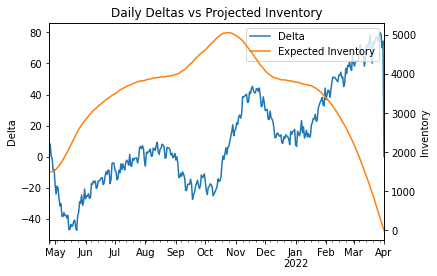

In [41]:
myModel.plot()